# Section 0 问题描述与完成项目流程

## 1. 问题描述


<img src="default.png" width="20%"></img>

在该项目中，你将使用强化学习算法，实现一个自动走迷宫机器人。

1. 如上图所示，智能机器人显示在右上角。在我们的迷宫中，有陷阱（红色炸弹）及终点（蓝色的目标点）两种情景。机器人要尽量避开陷阱、尽快到达目的地。
2. 小车可执行的动作包括：向上走 `u`、向右走 `r`、向下走 `d`、向左走 `l`。
3. 执行不同的动作后，根据不同的情况会获得不同的奖励，具体而言，有以下几种情况。
    - 撞到墙壁：-10
    - 走到终点：50
    - 走到陷阱：-30
    - 其余情况：-0.1
4. 我们需要通过修改 `robot.py` 中的代码，来实现一个 Q Learning 机器人，实现上述的目标。

## 2. 完成项目流程

1. 配置环境，使用 `envirnment.yml` 文件配置名为 `robot-env` 的 conda 环境，具体而言，你只需转到当前的目录，在命令行/终端中运行如下代码，稍作等待即可。
```
conda env create -f envirnment.yml
```
安装完毕后，在命令行/终端中运行 `source activate robot-env`（Mac/Linux 系统）或 `activate robot-env`（Windows 系统）激活该环境。

2. 阅读 `main.ipynb` 中的指导完成项目，并根据指导修改对应的代码，生成、观察结果。
3. 导出代码与报告，上传文件，提交审阅并优化。
---

---

# Section 1 算法理解


## 1. 1 强化学习总览

强化学习作为机器学习算法的一种，其模式也是让智能体在“训练”中学到“经验”，以实现给定的任务。但不同于监督学习与非监督学习，在强化学习的框架中，我们更侧重通过智能体与环境的**交互**来学习。通常在监督学习和非监督学习任务中，智能体往往需要通过给定的训练集，辅之以既定的训练目标（如最小化损失函数），通过给定的学习算法来实现这一目标。然而在强化学习中，智能体则是通过其与环境交互得到的奖励进行学习。这个环境可以是虚拟的（如虚拟的迷宫），也可以是真实的（自动驾驶汽车在真实道路上收集数据）。


在强化学习中有五个核心组成部分，它们分别是：**环境（Environment）**、**智能体（Agent）**、**状态（State）**、**动作（Action）**和**奖励（Reward）**。在某一时间节点 $t$：
    
- 智能体在从环境中感知其所处的状态 $s_t$
- 智能体根据某些准则选择动作 $a_t$
- 环境根据智能体选择的动作，向智能体反馈奖励 $r_{t+1}$

通过合理的学习算法，智能体将在这样的问题设置下，成功学到一个在状态 $s_t$ 选择动作 $a_t$ 的策略 $\pi (s_t) = a_t$。

---

**问题 1**：请参照如上的定义，描述出 “机器人走迷宫这个问题” 中强化学习五个组成部分对应的实际对象：

- **环境** : 迷宫，有陷阱（红色炸弹）及终点（蓝色的目标点）两种情景。个体所在时空，能够对个体所在状态和行为作出反馈，并能自我更新状态。在实际项目中，环境是指的机器人所在的迷宫空间。
- **状态** : 墙壁，终点，陷阱，其他情况。是所有可以决定未来的已有信息。从环境和个体来说，这个状态应该是包括个体状态和环境状态，一般描述个体状态 ${S_t=f(H_t)}$。在实际项目中，状态是指机器人在某个时间点上的信息，这类信息是机器人在环境中所处的坐标位置信息。


- **动作** : 个体在某个时刻下作出的行动，其能够引起个体和环境状态的变化。一般使用 ${a}$ 表示动作。实际项目中，动作指的是机器人在某个状态下采取的可能能够带来状态改变的行动，例如机器人向上、向下、向左以及向右的动作。
- **奖励** : 个体在某个时刻 t 得到的一个信号反馈，其是一个标量。实际项目中，奖励指的是机器人在某个状态或动作下得到的相关信号，例如不同方向上得到的不同奖励，以及在环境中达到目标和遇到陷阱得到的不同奖励信息反馈。

$$T(s^{'}, a, s) = P(s^{'}|a,s)$$


---

## 1.2 计算 Q 值 

在我们的项目中，我们要实现基于 Q-Learning 的强化学习算法。Q-Learning 是一个值迭代（Value Iteration）算法。与策略迭代（Policy Iteration）算法不同，值迭代算法会计算每个”状态“或是”状态-动作“的值（Value）或是效用（Utility），然后在执行动作的时候，会设法最大化这个值。因此，对每个状态值的准确估计，是我们值迭代算法的核心。通常我们会考虑**最大化动作的长期奖励**，即不仅考虑当前动作带来的奖励，还会考虑动作长远的奖励。

在 Q-Learning 算法中，我们把这个长期奖励记为 Q 值，我们会考虑每个 ”状态-动作“ 的 Q 值，具体而言，它的计算公式为：

$$
q(s_{t},a) = R_{t+1} + \gamma \times\max_a q(a,s_{t+1})
$$

也就是对于当前的“状态-动作” $(s_{t},a)$，我们考虑执行动作 $a$ 后环境给我们的奖励 $R_{t+1}$，以及执行动作 $a$ 到达 $s_{t+1}$后，执行任意动作能够获得的最大的Q值 $\max_a q(a,s_{t+1})$，$\gamma$ 为折扣因子。

不过一般地，我们使用更为保守地更新 Q 表的方法，即引入松弛变量 $alpha$，按如下的公式进行更新，使得 Q 表的迭代变化更为平缓。

$$
q(s_{t},a) = (1-\alpha) \times q(s_{t},a) + \alpha \times(R_{t+1} + \gamma \times\max_a q(a,s_{t+1}))
$$

# 
---
<img src="default2.png" width="20%"></img>

**问题 2**：根据已知条件求 $q(s_{t},a)$，在如下模板代码中的空格填入对应的数字即可。


已知：如上图，机器人位于 $s_1$，行动为 `u`，行动获得的奖励与题目的默认设置相同。在 $s_2$ 中执行各动作的 Q 值为：`u`: -24，`r`: -13，`d`: -0.29、`l`: +40，$\gamma$ 取0.9。


$$
\begin{align}
q(s_{t},a) & = R_{t+1} + \gamma \times\max_a q(a,s_{t+1}) \\
 & =(-0.1) + (0.9)*(40) \\
 & =(35.9)
\end{align}
$$


---

## 1.3 如何选择动作

在强化学习中，「探索-利用」问题是非常重要的问题。具体来说，根据上面的定义，我们会尽可能地让机器人在每次选择最优的决策，来最大化长期奖励。但是这样做有如下的弊端：
1. 在初步的学习中，我们的 Q 值会不准确，如果在这个时候都按照 Q 值来选择，那么会造成错误。
2. 学习一段时间后，机器人的路线会相对固定，则机器人无法对环境进行有效的探索。

因此我们需要一种办法，来解决如上的问题，增加机器人的探索。由此我们考虑使用 epsilon-greedy 算法，即在小车选择动作的时候，以一部分的概率随机选择动作，以一部分的概率按照最优的 Q 值选择动作。同时，这个选择随机动作的概率应当随着训练的过程逐步减小。

---

**问题 3**：在如下的代码块中，实现 epsilon-greedy 算法的逻辑，并运行测试代码。

In [25]:
import random

actions = ['u','r','d','l']
qline = {'u':1.2, 'r':-2.1, 'd':-24.5, 'l':27}
epsilon = 0.3 # 以0.3的概率进行随机选择

def choose_action(epsilon):
    
    action = None
    if random.random() < epsilon: # 以某一概率
        action = random.choice(actions) # 实现对动作的随机选择
    else: 
        action = sorted(qline, key=lambda x:qline[x], reverse=True)[0]# 否则选择具有最大 Q 值的动作
    return action

---

---

# Section 2 代码实现

## 2.1. `Maze` 类理解

我们首先引入了迷宫类 `Maze`，这是一个非常强大的函数，它能够根据你的要求随机创建一个迷宫，或者根据指定的文件，读入一个迷宫地图信息。

1. 使用 `Maze("file_name")` 根据指定文件创建迷宫，或者使用 `Maze(maze_size=(height,width))` 来随机生成一个迷宫。
2. 使用 `trap_number` 参数，在创建迷宫的时候，设定迷宫中陷阱的数量。
3. 直接键入迷宫变量的名字按回车，展示迷宫图像（如 `g=Maze("xx.txt")`，那么直接输入 `g` 即可。
4. 建议生成的迷宫尺寸，长在 6~12 之间，宽在 10～12 之间。

---

**问题 4**：在如下的代码块中，创建你的迷宫并展示。

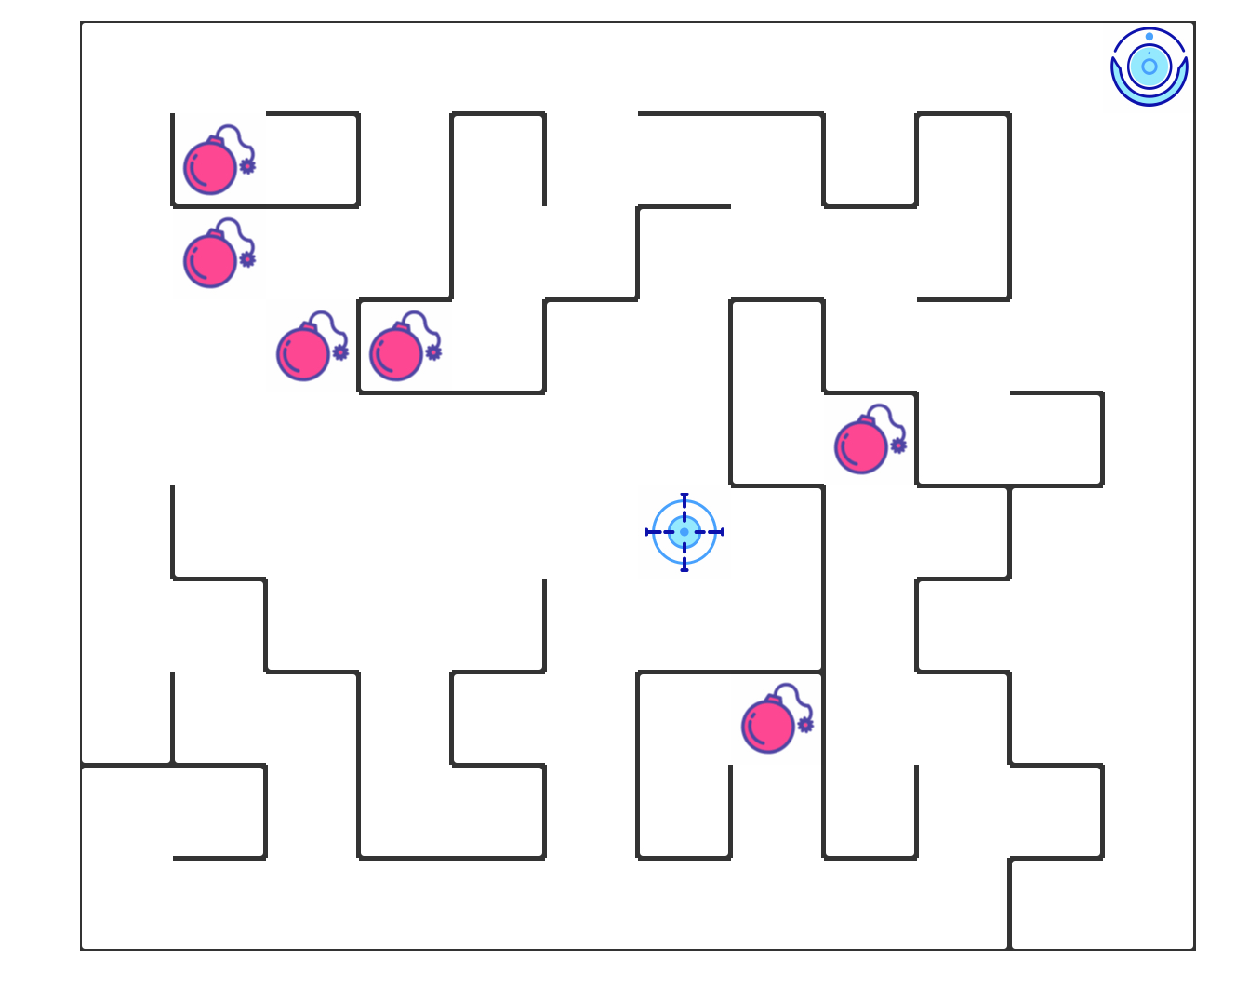

Maze of size (10, 12)


In [26]:
from Maze import Maze
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
maze_world = Maze("./test_world/maze_01.txt", maze_size=(10, 12), trap_number=6)

## todo: 创建迷宫并展示
print(maze_world)

In [ ]:
---

你可能已经注意到，在迷宫中我们已经默认放置了一个机器人。实际上，我们为迷宫配置了相应的 API，来帮助机器人的移动与感知。其中你随后会使用的两个 API 为 `maze.sense_robot()` 及 `maze.move_robot()`。

1. `maze.sense_robot()` 为一个无参数的函数，输出机器人在迷宫中目前的位置。
2. `maze.move_robot(direction)` 对输入的移动方向，移动机器人，并返回对应动作的奖励值。

---

**问题 5**：随机移动机器人，并记录下获得的奖励，展示出机器人最后的位置。

(2, 11)


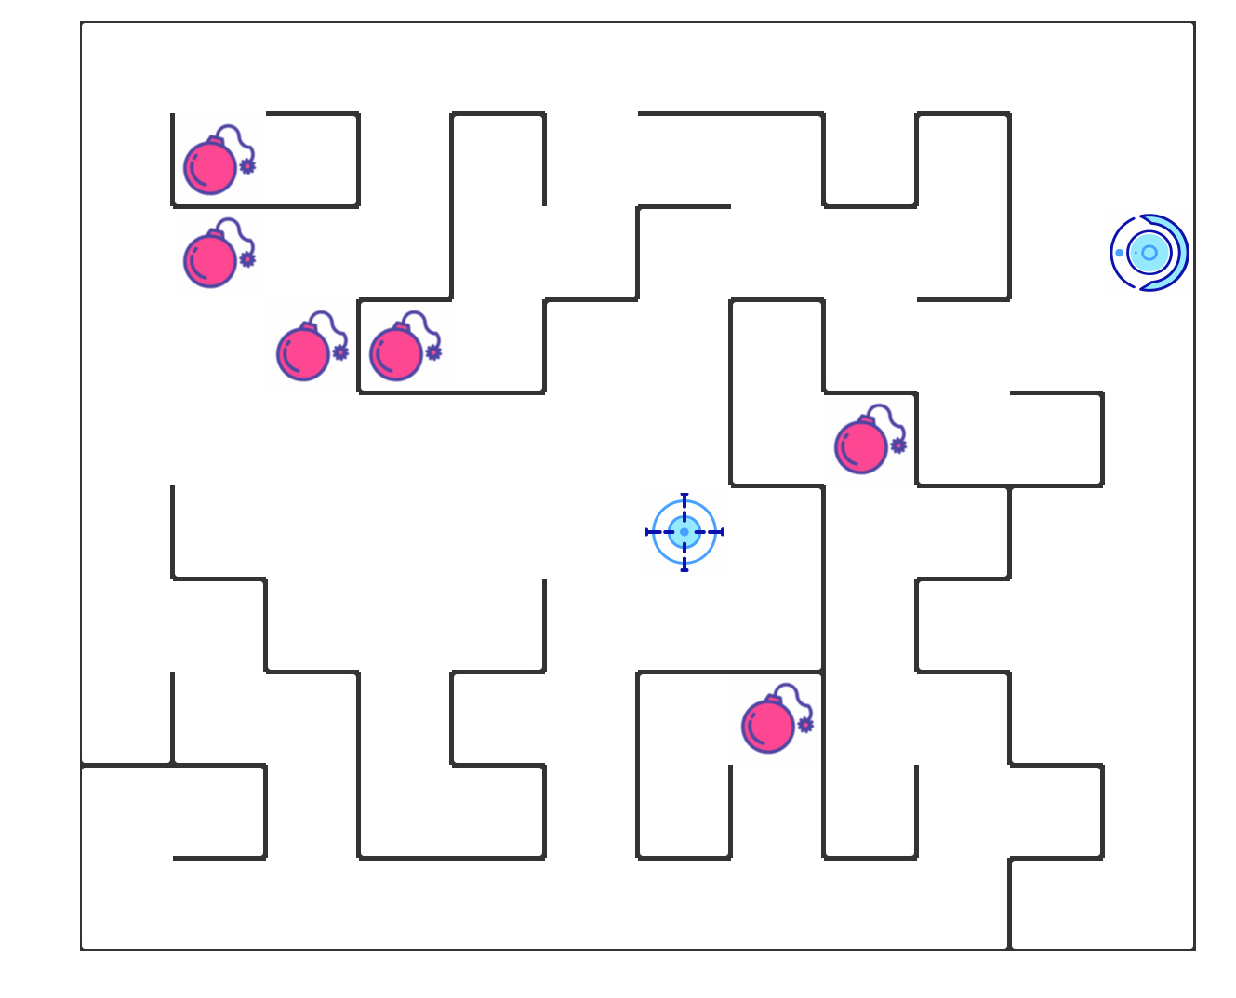

Maze of size (10, 12)


In [27]:
rewards = []

## 循环、随机移动机器人10次，记录下奖励
for i in range(10):
    maze_world.move_robot(random.choice(actions))

## 输出机器人最后的位置
print(maze_world.sense_robot())

## 打印迷宫，观察机器人位置
print(maze_world)

## 2.2. `Robot` 类实现

`Robot` 类是我们需要重点实现的部分。在这个类中，我们需要实现诸多功能，以使得我们成功实现一个强化学习智能体。总体来说，之前我们是人为地在环境中移动了机器人，但是现在通过实现 `Robot` 这个类，机器人将会自己移动。通过实现学习函数，`Robot` 类将会学习到如何选择最优的动作，并且更新强化学习中对应的参数。

首先 `Robot` 有多个输入，其中 `alpha=0.5, gamma=0.9, epsilon0=0.5` 表征强化学习相关的各个参数的默认值，这些在之前你已经了解到，`Maze` 应为机器人所在迷宫对象。

随后观察 `Robot.update` 函数，它指明了在每次执行动作时，`Robot` 需要执行的程序。按照这些程序，各个函数的功能也就明了了。

最后你需要实现 `Robot.py` 代码中的8段代码，他们都在代码中以 `#TODO` 进行标注，你能轻松地找到他们。

---

**问题 6**：实现 `Robot.py` 中的8段代码，并运行如下代码检查效果（记得将 `maze` 变量修改为你创建迷宫的变量名）。



In [28]:
from Robot import Robot
robot = Robot(maze_world) # 记得将 maze 变量修改为你创建迷宫的变量名
robot.set_status(learning=True,testing=False)
print(robot.update())

('l', -0.1)


---

## 2.3 用 `Runner` 类训练 Robot

在实现了上述内容之后，我们就可以开始对我们 `Robot` 进行训练并调参了。我们为你准备了又一个非常棒的类 `Runner`，来实现整个训练过程及可视化。使用如下的代码，你可以成功对机器人进行训练。并且你会在当前文件夹中生成一个名为 `filename` 的视频，记录了整个训练的过程。通过观察该视频，你能够发现训练过程中的问题，并且优化你的代码及参数。

---

**问题 7**：尝试利用下列代码训练机器人，并进行调参。可选的参数包括：

- 训练参数
    - 训练次数 `epoch`
- 机器人参数：
    - `epsilon0` (epsilon 初值)
    - `epsilon`衰减（可以是线性、指数衰减，可以调整衰减的速度），你需要在 Robot.py 中调整
    - `alpha`
    - `gamma`
- 迷宫参数:
    - 迷宫大小
    - 迷宫中陷阱的数量

In [30]:
## 可选的参数：
epoch = 20

epsilon0 = 0.3
alpha = 0.5
gamma = 0.9

maze_size = (6,6)
trap_number = 1

In [31]:
from Runner import Runner

g = Maze(maze_size=maze_size,trap_number=trap_number)
r = Robot(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

runner = Runner(r, g)
runner.run_training(epoch, display_direction=True)
runner.generate_movie(filename = "final1.mp4") # 你可以注释该行代码，加快运行速度，不过你就无法观察到视频了。

Generate Movies: 100%|███████████████████████| 386/386 [00:12<00:00, 31.54it/s]


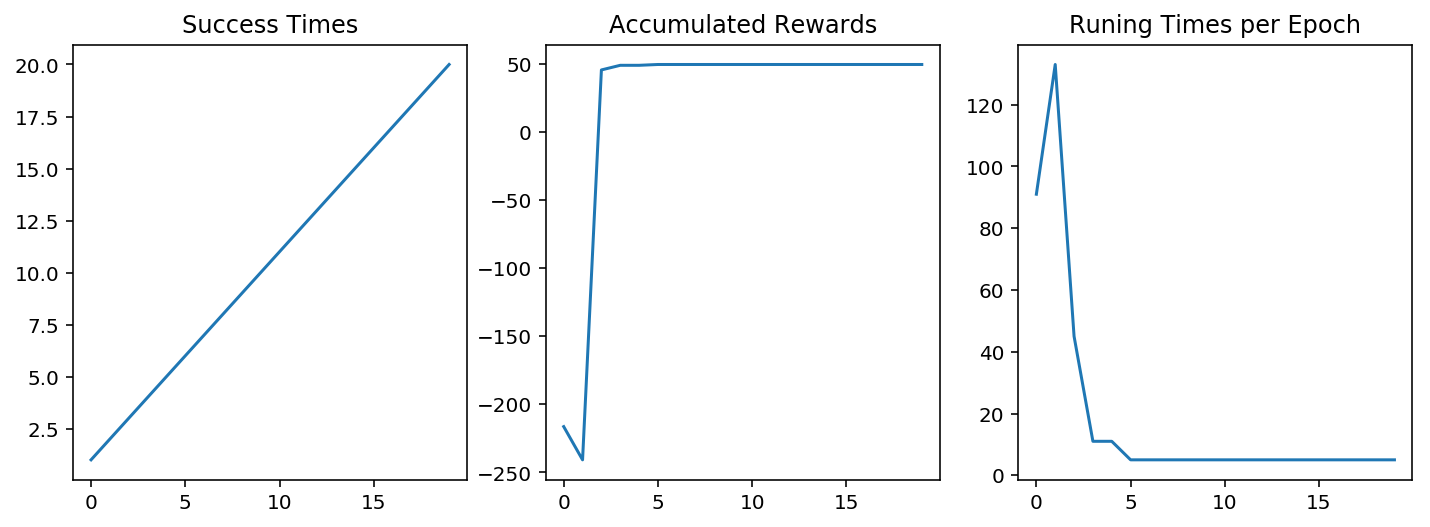

In [32]:
runner.plot_results()

---

使用 `runner.plot_results()` 函数，能够打印机器人在训练过程中的一些参数信息。

- Success Times 代表机器人在训练过程中成功的累计次数，这应当是一个累积递增的图像。
- Accumulated Rewards 代表机器人在每次训练 epoch 中，获得的累积奖励的值，这应当是一个逐步递增的图像。
- Running Times per Epoch 代表在每次训练 epoch 中，小车训练的次数（到达终点就会停止该 epoch 转入下次训练），这应当是一个逐步递减的图像。

---

**问题 8**：使用 `runner.plot_results()` 输出训练结果，根据该结果对你的机器人进行分析。

- 指出你选用的参数如何，选用参数的原因。
- 建议你比较不同参数下机器人的训练的情况。
- 训练的结果是否满意，有何改进的计划。

In [33]:
## 可选的参数：
epoch = 20

epsilon0 = 0.8
alpha = 0.5
gamma = 0.9

maze_size = (6,6)
trap_number = 1

In [34]:
from Runner import Runner

g = Maze(maze_size=maze_size,trap_number=trap_number)
r = Robot(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

runner = Runner(r, g)
runner.run_training(epoch, display_direction=True)
runner.generate_movie(filename = "final1.mp4") 

Generate Movies: 100%|███████████████████████| 312/312 [00:08<00:00, 36.94it/s]


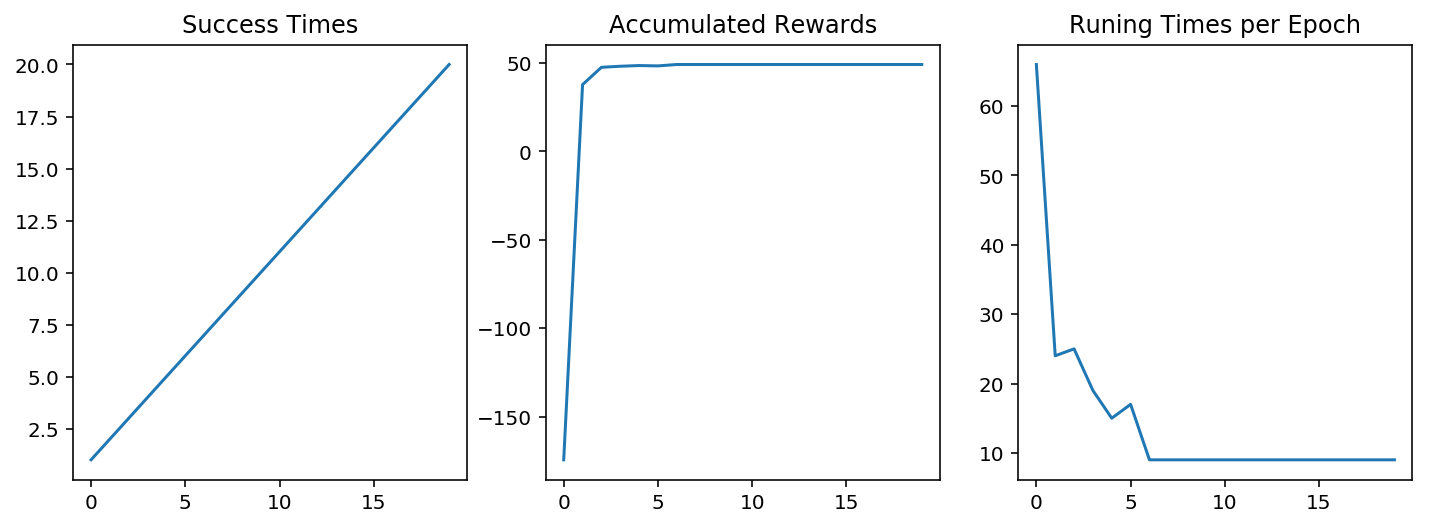

In [35]:
runner.plot_results()

In [36]:
## 可选的参数：
epoch = 20

epsilon0 = 0.3
alpha = 0.5
gamma = 0.2

maze_size = (6,6)
trap_number = 1

In [37]:
from Runner import Runner

g = Maze(maze_size=maze_size,trap_number=trap_number)
r = Robot(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

runner = Runner(r, g)
runner.run_training(epoch, display_direction=True)

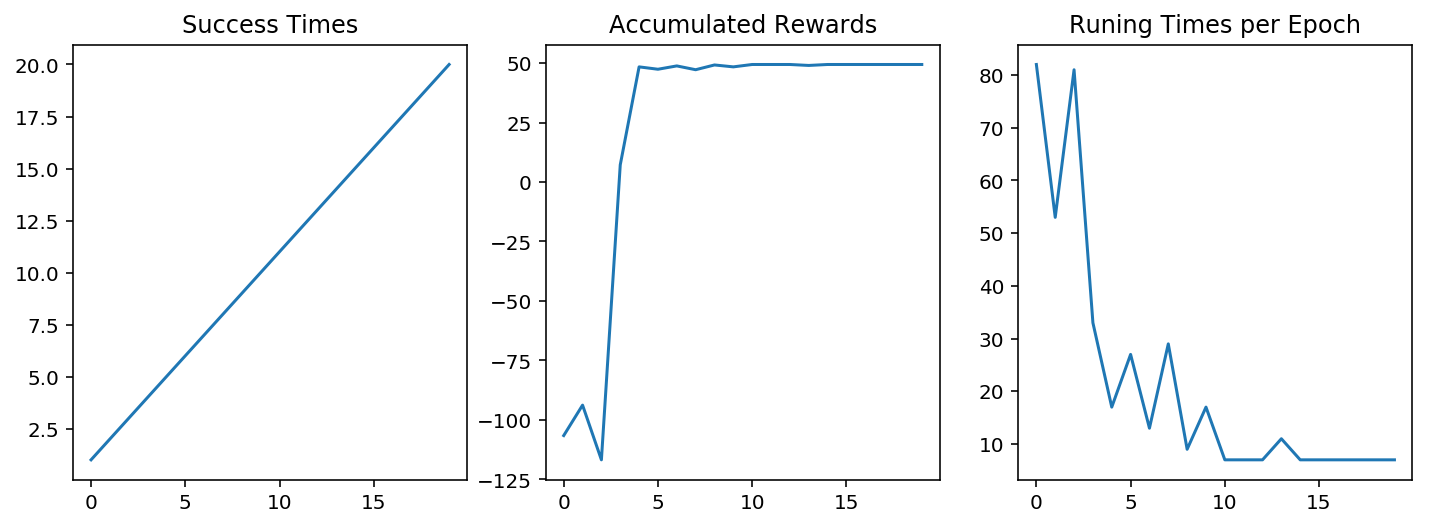

In [38]:
runner.plot_results()

(回答区)

1. 训练参数
训练次数 epoch，回合数20次
不同参数上仅调整了 gamma，分别使用了 0.9 和 0.2 两个值——是希望测试一下训练模型分别对注重长期奖励和当前奖励的角度的不同表现

epsilon0 (epsilon 初值)，epsilon初始值为0.3，在刚开始的时候，算法能够接触到更多的state；
epsilon随着学习，不断衰减，让小车更大的几率按照Q learning的结果运行，这里选用了线性衰减；
alpha的权重更大取0.5；
gamma考虑执行行动时的奖励，取0.9, 改变gama时，值太小收敛速度比较慢；

maze_size 和 trap_number 分别为 6 X 6 的环境以及使用了一个 1 个陷阱数量，因为这个只是一个测试模型，把环境尽量控制到可用的最小环境；本身环境不是太大，因此不适宜设置太多陷阱。

2. 两次不同的 gamma 值来看，两次都得到了比较好的结果。
在每次运行次数方面， gamma 为 0.9 的表现较好，在 5 轮之后相对能达到收敛。而使用 0.2 的 gamma 值波动太大。

3. 训练结果方面还是比较满意，同时了解到了不同 gamma 值的情况下模型收敛情况：

解决实际情况的时候，环境更复杂。因为实际中，环境也可能是动态的。因此这个方面还需要去改进
本次使用的迷宫环境不是太大，还可以考虑从增大迷宫环境等角度出发进行尝试
对模型理解不深入，因为在实际参数调整方面还没有深入

---

**问题 9：** 请将如下的文件打包，提交文件给审阅者。

- `robot.py`
- `robot_maze.ipynb`
- 由 `robot_maze.ipynb` 导出的 `robot_maze.html`